# BERT Notebook

Author: Mike Caswell

Submission Date: 5th August 2024

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')

STOPWORDS=set(stopwords.words('english'))

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds

# BERT
import transformers
from transformers import AutoTokenizer, TFAutoModel

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
import tqdm
import warnings

warnings.filterwarnings("ignore")
stemmer = nltk.SnowballStemmer("english")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

random.seed(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thecaswell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


``Functions``

In [2]:
# Clean text
def clean(text):
    text=str(text).lower()
     # Remove text within square brackets
    text=re.sub('\[.*?\]','',text)
    # Remove URLs
    text=re.sub('https?://\S+|www\.\S+','',text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    #  Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace newline characters with spaces
    text = re.sub('\n', '', text)
    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)
     # Tokenize the text and remove stopwords
    text = [word for word in text.split(' ') if word not in STOPWORDS]
    text=" ".join(text)
    # Stem the remaining words
    text = [stemmer.stem(word) for word in text.split(' ')]
    # Join the cleaned and stemmed words back into a string
    text=" ".join(text)
    return text

In [3]:
# Tokenize Data
def tokenize(reviews, labels, tokenizer, seq_length):
    ''''''
    # tokenize reviews (this will give you: input_ids, token_type_ids, attention_mask)
    reviews_tokenized = [
        tokenizer(
            n,
            return_tensors='tf',
            truncation=True,
            padding='max_length',
            max_length=seq_length) for n in reviews
    ]

    reviews_tokenized_tensor = tf.convert_to_tensor([
                            (reviews_tokenized[i]['input_ids'],
                              reviews_tokenized[i]['token_type_ids'],
                              reviews_tokenized[i]['attention_mask'])
                         for i in range(len(reviews_tokenized))
    ])

    # remove empty dimension
    reviews_tokenized_tensor = reviews_tokenized_tensor[:,:,0,:]

    # tensor labels
    labels_tensor = np.array(labels)

    return reviews_tokenized_tensor, labels_tensor

In [4]:
# Create BERT Embeddings
def get_bert_embeddings(bert_auto_model, reviews_tokenized_tensor, feature_size=768):
    ''''''
    n = len(reviews_tokenized_tensor)
    seq_len = reviews_tokenized_tensor[0][0].shape[0]
    bert_pool_embeddings = np.zeros((n, feature_size)) 
    bs = 128
    nsteps = n//bs+1

    for i in tqdm.trange(n//bs+1):
        slc = slice(i*bs, (i+1)*bs)
        data = reviews_tokenized_tensor[slc]
        input_ids, token_type_ids, attention_mask = data[:,0], data[:,1], data[:,2]
        embedding = bert_auto_model(input_ids, token_type_ids, attention_mask).pooler_output # for sentence embeddings
        bert_pool_embeddings[slc] = embedding

    return bert_pool_embeddings

In [6]:
# Function for grouping scores as positive (1) or negative (0)
def group(score):
    if score > 3:
        return 1
    elif score <= 3:
        return 0
        
# Load data, but this may be different 
df = pd.read_pickle("~/kaggle/working/transformer_preprocessed_data.pkl")

# Keeping only the first of any duplicates
df.drop_duplicates(subset=['Text','Score'],keep='first',inplace=True)
df = df[df['Sentiment']!='neutral']
df = df[df['Score']!=3]

# Drop all conflicting reviews
df = df[~((df['Score'] >= 4) & (df['Sentiment'] != 'positive'))]
df = df[~((df['Score'] <= 2) & (df['Sentiment'] != 'negative'))]
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Probablities
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,"[0.009624186, 0.049980223, 0.9403955]"
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,"[0.5089858, 0.4524138, 0.03860041]"
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive,"[0.0032289024, 0.09806721, 0.8987039]"
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,"[0.0016347261, 0.010302446, 0.98806286]"
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,positive,"[0.0061295927, 0.021795845, 0.97207457]"


In [7]:
# Apply clean and group functions+
df['Text'] = df["Text"].apply(clean)
df['Score'] = df['Score'].apply(group)
text = df['Text'].values

In [8]:
# split = [60, 20, 20]
train_valid_reviews, test_reviews, train_valid_labels, test_labels =train_test_split(
    df.Text,
    df.Sentiment,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

train_reviews, valid_reviews, train_labels, valid_labels = train_test_split(
    train_valid_reviews,
    train_valid_labels,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

In [9]:
# Review sizes of train, valid, and test s4ts
print('Size train reviews:', len(train_reviews))
print('Size dev reviews', len(valid_reviews))
print('Size test reviews', len(test_reviews))

Size train reviews: 208410
Size dev reviews 52103
Size test reviews 65129


``Step 4: Pre-trained embeddings``

In [10]:
# Instance model and tokenizer
hf_model = "bert-base-uncased"
if 'tokenizer' not in locals().keys(): tokenizer = AutoTokenizer.from_pretrained(hf_model)
if 'bert_auto_model' not in locals().keys(): bert_model = TFAutoModel.from_pretrained(hf_model)
tokenizer = AutoTokenizer.from_pretrained(hf_model)
bert_model = TFAutoModel.from_pretrained(hf_model)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
# Prepare for embeddings
seq_length = 128  # Define the sequence length
train_reviews_tokenized, train_labels_tensor = tokenize(train_reviews, train_labels, tokenizer, seq_length)
valid_reviews_tokenized, valid_labels_tensor = tokenize(valid_reviews, valid_labels, tokenizer, seq_length)
test_reviews_tokenized, test_labels_tensor = tokenize(test_reviews, test_labels, tokenizer, seq_length)

In [12]:
# Create emeddings
train_embeddings = get_bert_embeddings(bert_model, train_reviews_tokenized)
valid_embeddings = get_bert_embeddings(bert_model, valid_reviews_tokenized)
test_embeddings = get_bert_embeddings(bert_model, test_reviews_tokenized)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [1:15:17<00:00,  8.88s/it]


In [13]:
# Save embeddings for future use, took 5 hours to run
np.save('train_embeddings.npy', train_embeddings)
np.save('valid_embeddings.npy', valid_embeddings)
np.save('test_embeddings.npy', test_embeddings)


In [24]:
# Create intial Neural Network
model = Sequential([
    Dense(256, activation='relu', input_shape=(train_embeddings.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_embeddings, train_labels_tensor, epochs=10, validation_data=(valid_embeddings, valid_labels_tensor))

Epoch 1/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8691 - loss: 0.3803 - val_accuracy: 0.8698 - val_loss: 0.3420
Epoch 2/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8700 - loss: 0.3436 - val_accuracy: 0.8702 - val_loss: 0.3368
Epoch 3/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8716 - loss: 0.3320 - val_accuracy: 0.8709 - val_loss: 0.3246
Epoch 4/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8724 - loss: 0.3256 - val_accuracy: 0.8732 - val_loss: 0.3143
Epoch 5/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8730 - loss: 0.3224 - val_accuracy: 0.8735 - val_loss: 0.3169
Epoch 6/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8753 - loss: 0.3165 - val_accuracy: 0.8785 - val_loss: 0.3035
Epoch 7/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8775 - loss: 0.3104 - val_accuracy: 0.8782 - val_loss: 0.3019
Epoch 8/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8791 - loss: 0

In [26]:
from sklearn.metrics import classification_report

# Make predictions on the test set
test_predictions = model.predict(test_embeddings)
test_predictions = (test_predictions > 0.5).astype(int)

# Generate the classification report for initial model
report = classification_report(test_labels_tensor, test_predictions, target_names=['Negative', 'Positive'])
print(report)


2036/2036 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step
              precision    recall  f1-score   support

    Negative       0.74      0.14      0.23      8556
    Positive       0.88      0.99      0.94     56573

    accuracy                           0.88     65129
   macro avg       0.81      0.57      0.58     65129
weighted avg       0.86      0.88      0.84     65129



In [29]:
# Define 2nd neural network model with class weights
model2 = Sequential([
    Dense(256, activation='relu', input_shape=(train_embeddings.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history2 = model2.fit(train_embeddings, train_labels_tensor, 
                    epochs=10, 
                    validation_data=(valid_embeddings, valid_labels_tensor),
                    class_weight=class_weight_dict,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])



# Extract accuracy and loss values from history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
# Generate the classification report for final model 
report = classification_report(test_labels_tensor, test_predictions, target_names=['Negative', 'Positive'])
print(report)

Epoch 1/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5500 - loss: 0.6818 - val_accuracy: 0.5661 - val_loss: 0.6953
Epoch 2/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6635 - loss: 0.6040 - val_accuracy: 0.6296 - val_loss: 0.6188
Epoch 3/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6848 - loss: 0.5779 - val_accuracy: 0.7217 - val_loss: 0.5386
Epoch 4/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6976 - loss: 0.5647 - val_accuracy: 0.7301 - val_loss: 0.5429
Epoch 5/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7145 - loss: 0.5509 - val_accuracy: 0.7583 - val_loss: 0.5023
Epoch 6/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7132 - loss: 0.5465 - val_accuracy: 0.7628 - val_loss: 0.4807
Epoch 7/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7176 - loss: 0.5406 - val_accuracy: 0.8051 - val_loss: 0.4307
Epoch 8/10
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7251 - loss: 0

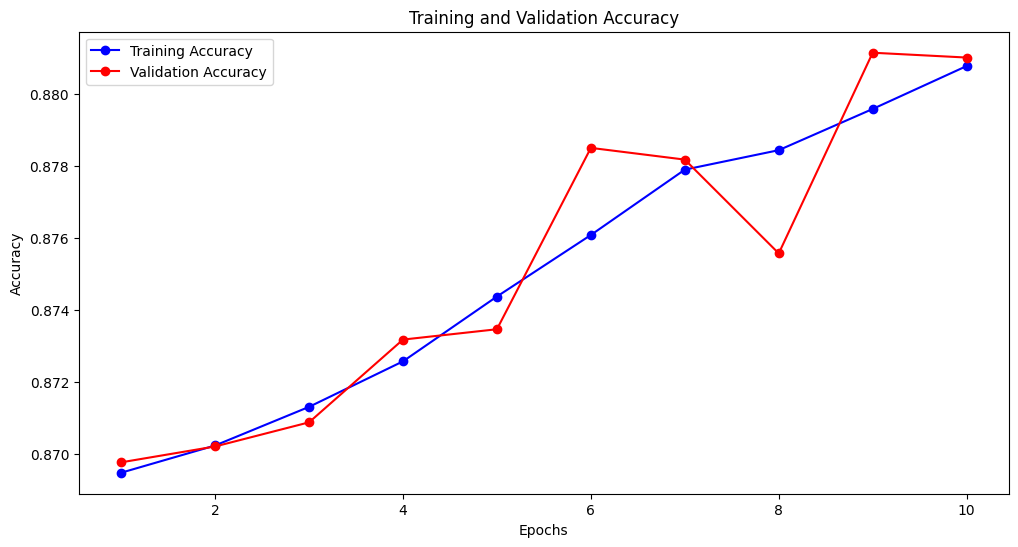

In [33]:
# Show scores per Epoch for final model
import matplotlib.pyplot as plt

# Extract accuracy and loss values from history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()